# 1. Import Libraries

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Load dataset
from ucimlrepo import fetch_ucirepo  

# Preprocessing and splitting
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

pd.options.display.max_columns = 60
# Settings for nicer plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries successfully imported.")

Libraries successfully imported.


# 2. Data Loading and Initial Exploration (EDA)

In [2]:
print("\n--- Starting Exploratory Data Analysis (EDA) ---")

print("[EDA] Loading data from UCIML repo (ID=31)...")
covertype = fetch_ucirepo(id=31) 

a = covertype.data.features  # pyright: ignore[reportOptionalMemberAccess]
b = covertype.data.targets['Cover_Type'] # pyright: ignore[reportOptionalMemberAccess]



--- Starting Exploratory Data Analysis (EDA) ---
[EDA] Loading data from UCIML repo (ID=31)...


In [3]:
# had some issues after dropping columns, so made copies
X = a.copy()
y = b.copy()

y = y - 1 # for XGBoost since it requires labels starting from 0
data = X.copy()
data['Cover_Type'] = y

print("\n[EDA] Dataset Information:")
print(data.info())

print("\n[EDA] First 5 rows of the dataset:")
print(data.head())

print("\n[EDA] Descriptive statistics:")
print(X.describe())


[EDA] Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1              


[EDA] Target variable distribution:


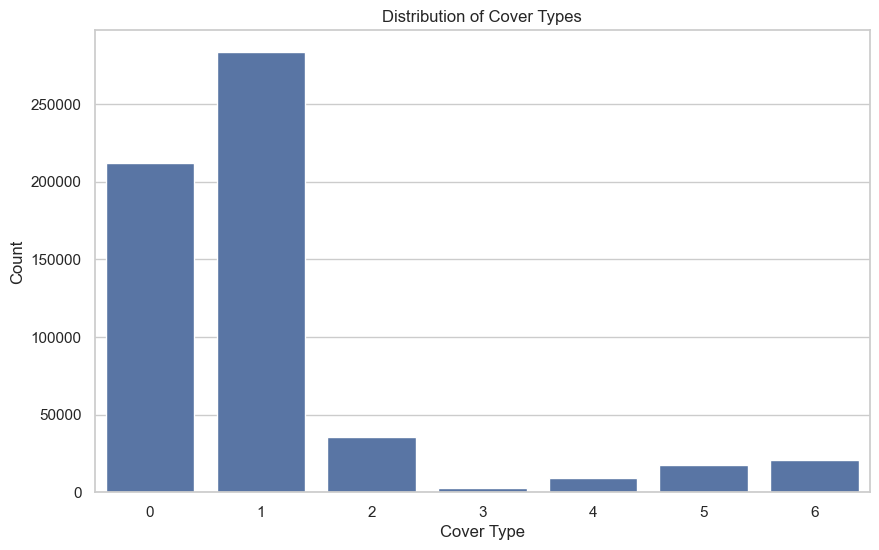


[EDA] Target variable distribution (%):
Cover_Type
0    36.460521
1    48.759922
2     6.153746
3     0.472796
4     1.633873
5     2.989095
6     3.530048
Name: proportion, dtype: float64


In [4]:
print("\n[EDA] Target variable distribution:")
sns.countplot(x=y)
plt.title("Distribution of Cover Types")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.show()

print("\n[EDA] Target variable distribution (%):")
print(y.value_counts(normalize=True).sort_index() * 100)

### Multicollinearity in one-hot encoded features


--- [EDA] Checking for Redundancy in Binary Columns ---
Wilderness_Area columns are one-hot encoded and sum to 1.
We can drop column, 'Wilderness_Area4', to remove this redundancy.

Soil_Type columns are one-hot encoded and sum to 1.
We can drop column, 'Soil_Type40', to remove this redundancy.

[EDA] Correlation matrix for Wilderness Area columns:


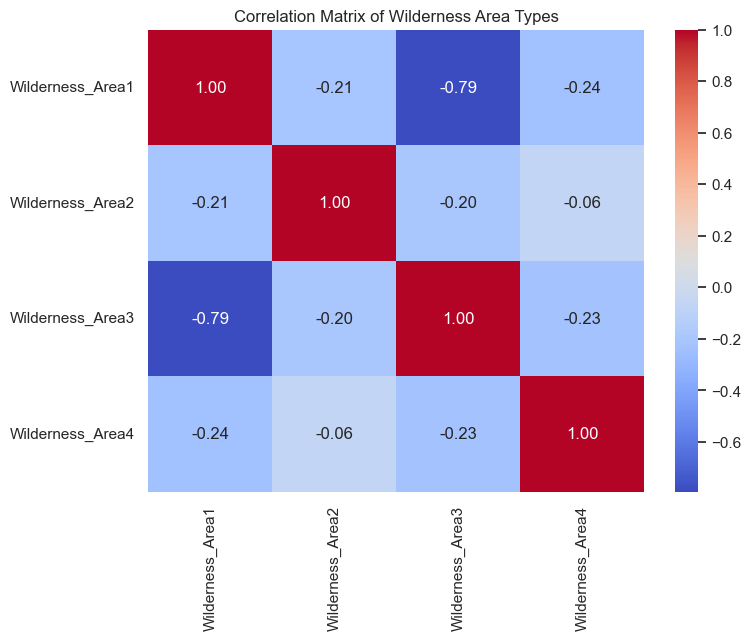

In [5]:
print("\n--- [EDA] Checking for Redundancy in Binary Columns ---")

wilderness_cols = [col for col in X.columns if 'Wilderness_Area' in col]
soil_cols = [col for col in X.columns if 'Soil_Type' in col]


wilderness_sum = X[wilderness_cols].sum(axis=1)
soil_sum = X[soil_cols].sum(axis=1)

if (wilderness_sum == 1).all():
    print("Wilderness_Area columns are one-hot encoded and sum to 1.")
    print(f"We can drop column, '{wilderness_cols[-1]}', to remove this redundancy.")

if (soil_sum == 1).all():
    print("\nSoil_Type columns are one-hot encoded and sum to 1.")
    print(f"We can drop column, '{soil_cols[-1]}', to remove this redundancy.")

print("\n[EDA] Correlation matrix for Wilderness Area columns:")
wilderness_corr = X[wilderness_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(wilderness_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Wilderness Area Types')
plt.show()

### Visualizing Feature Relationships

Since it takes quite a while to plot all half a million data points, 
I sampled only 3~20% of it

In [6]:
sampled03 = data.groupby(y, group_keys=False).apply(lambda x: x.sample(frac=0.03, random_state=42))
sampled05 = data.groupby(y, group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))
sampled20 = data.groupby(y, group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))
cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
       'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type']

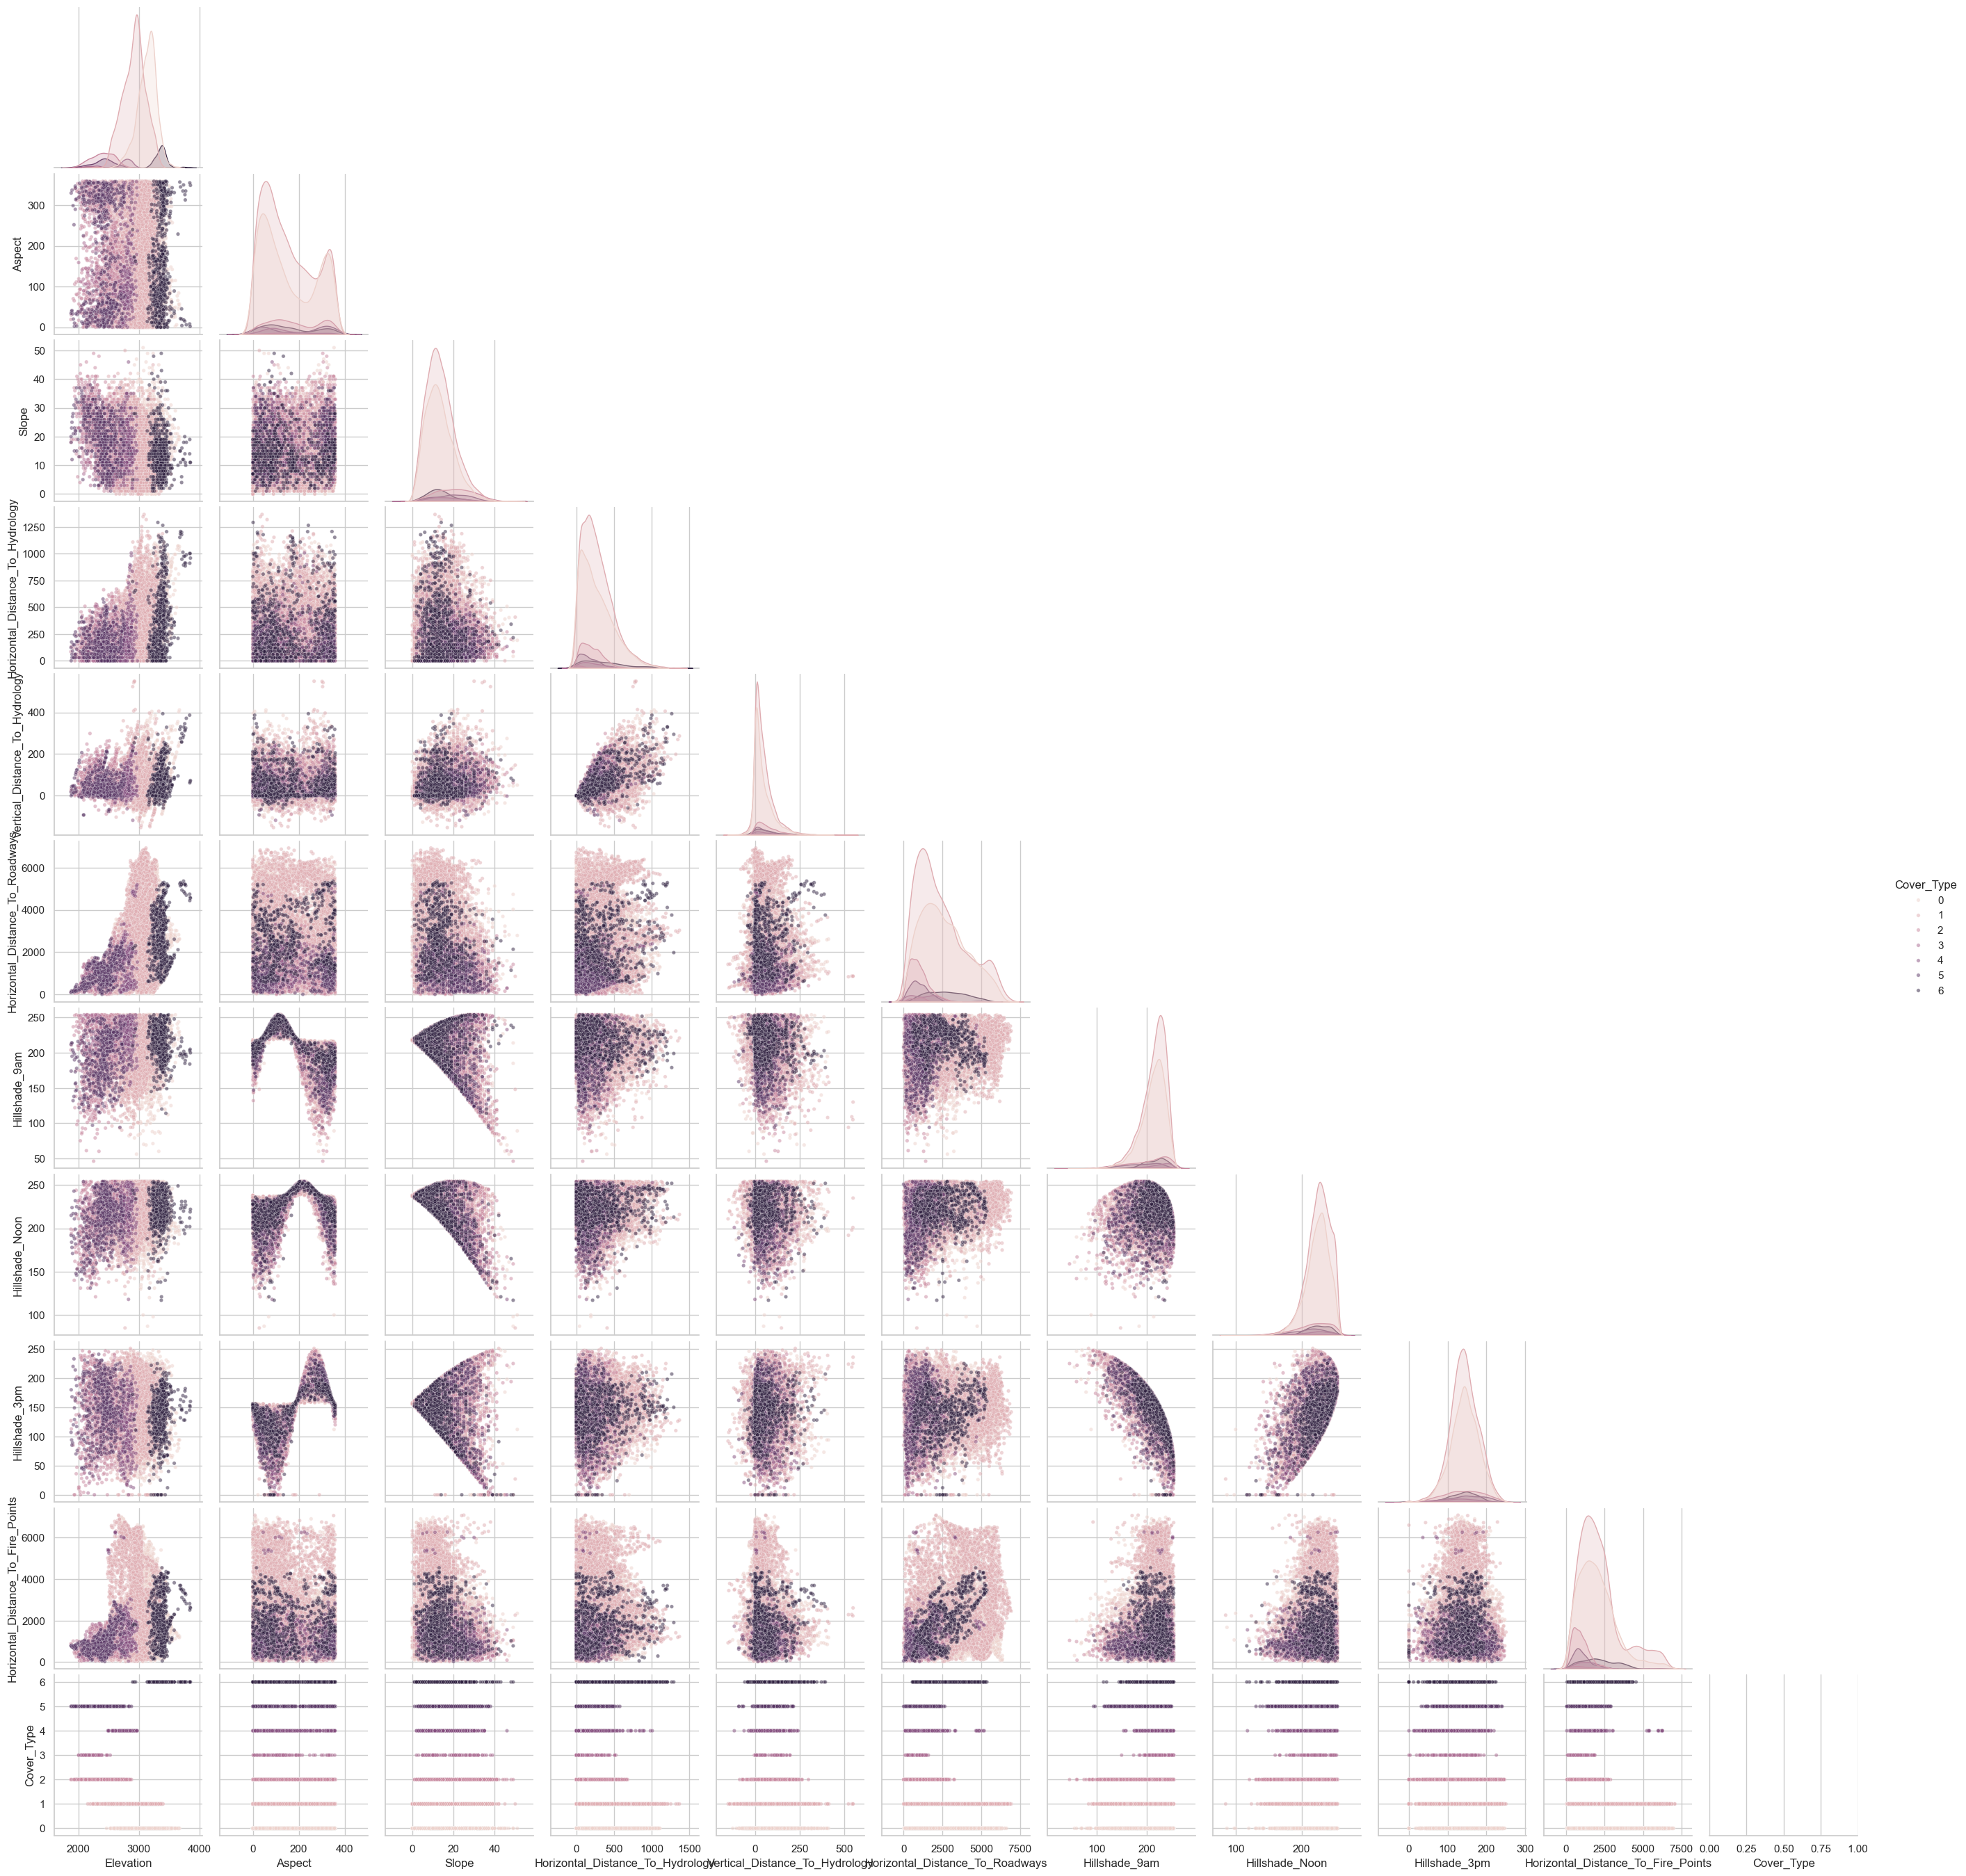

In [7]:
sns.pairplot(data=sampled03, vars=cols, hue="Cover_Type", corner=True, plot_kws={'alpha':0.5, 's':15})

### Investigating pairplot

From the pairplot, Elevation appears to be a highly discriminative feature.

Also horizontal distances seem to be clustering nicely

I'm doubting the importance of Hillshade at any time since it just seems to be a result of elevation, slope and aspect..
Though I'm definitely removing two of them since they are clearly correlated 

### Analyzing Elevation

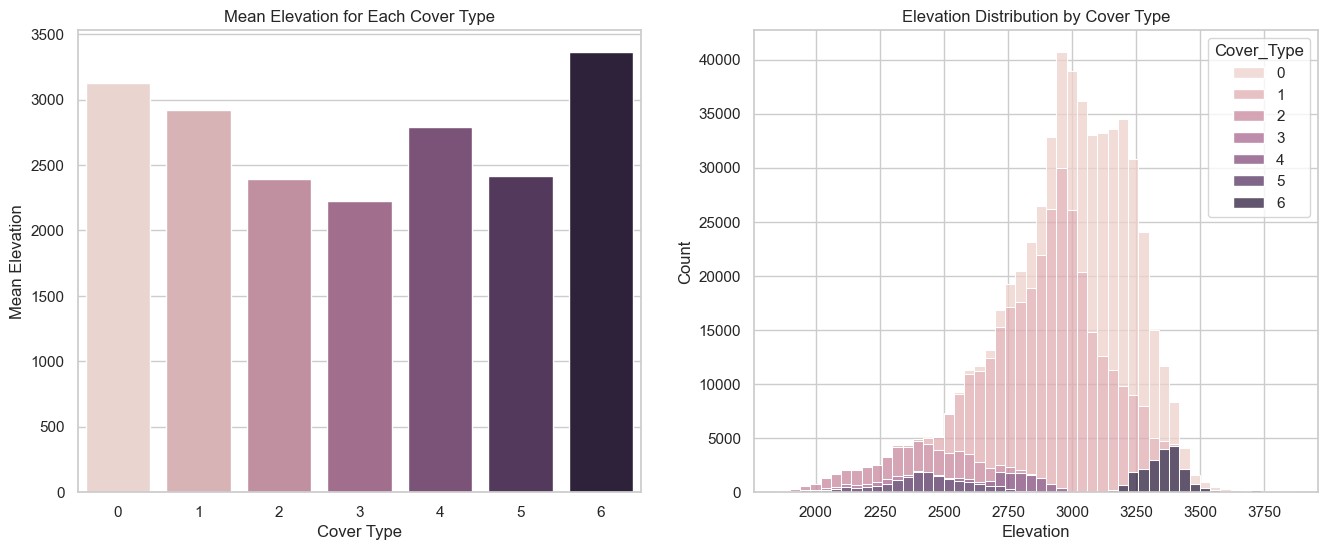

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean Elevation per Cover Type
typeElevation = {}
for type in range(0,7):
    typeElevation[type]=(data[data['Cover_Type'] == type]['Elevation'].mean())
sns.barplot(x=list(typeElevation.keys()), y=list(typeElevation.values()), ax=axes[0], hue=list(typeElevation.keys()), legend=False)
axes[0].set_title('Mean Elevation for Each Cover Type')
axes[0].set_xlabel('Cover Type')
axes[0].set_ylabel('Mean Elevation')

# Plot 2: Elevation Distribution
sns.histplot(data=data, x='Elevation', hue='Cover_Type', multiple='stack', bins=50, ax=axes[1])
axes[1].set_title('Elevation Distribution by Cover Type')

plt.show()

### Analyzing Hillshade

The dataset contains `Hillshade_9am`, `Hillshade_Noon`, and `Hillshade_3pm`. These features seem to be highly correlated since they all measure sunlight just at different times of the day.

So I will only keep `Hillshade_9am`

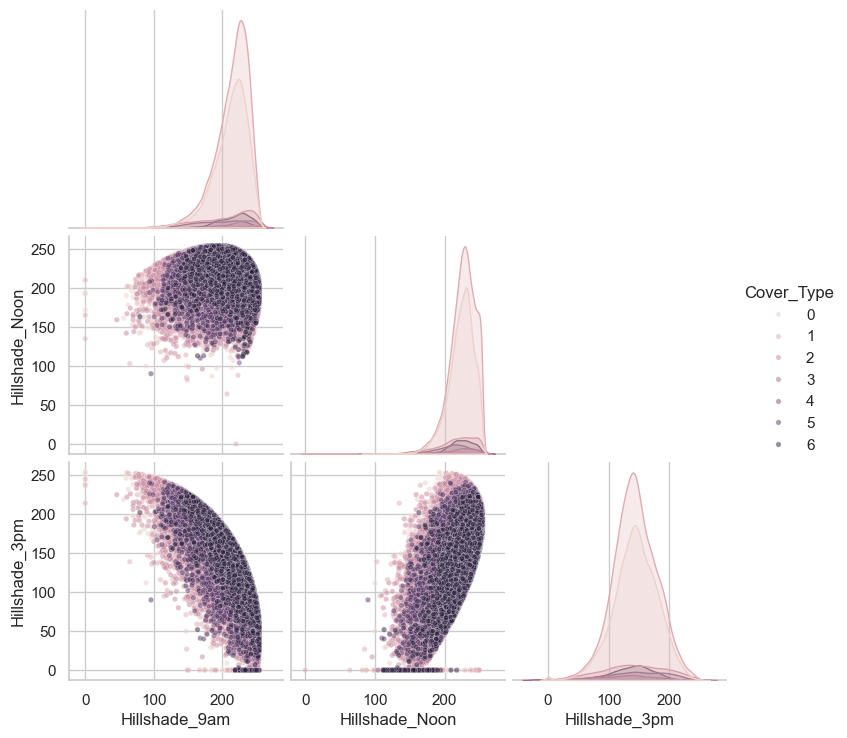

In [9]:
sns.pairplot(sampled20, vars=['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'],
             hue='Cover_Type', corner=True, plot_kws={'alpha':0.5, 's':15})

# 3. Data Preprocessing and Feature Engineering

1.  **Dropping Redundant Features**: Removing the `Hillshade_Noon` and `Hillshade_3pm` columns as well as one binary feature per group as decided in the EDA phase.
2.  **Identifying Feature Types**: Separating the columns into quantitative (numerical) and binary (0/1) features.
3.  **Splitting the Data**: Dividing the dataset into training (80%) and testing (20%) sets. Using stratified sampling to ensure the proportion of each cover type is the same in both sets.
4.  **Scaling Quantitative Features**: Applying `StandardScaler` to the quantitative features. This standardizes them to have a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms. The binary features are left untouched.

In [10]:
print("\n--- Starting Data Preprocessing ---")

# According to the dataset description:
# The first 10(-2) columns are quantitative
X = X.drop(columns=['Hillshade_Noon', 'Hillshade_3pm'], errors='ignore') 
quantitative_cols = X.columns[:8]
# quantitative_cols = X.columns[:10]

# The remaining 44(-2) are binary (Wilderness_Area and Soil_Type)
X = X.drop(columns=['Wilderness_Area4', 'Soil_Type40'], errors='ignore')
binary_cols = X.columns[8:]
# binary_cols = X.columns[10:]

# print(quantitative_cols)

print(f"Found {len(quantitative_cols)} quantitative columns.")
print(f"Found {len(binary_cols)} binary columns.")


--- Starting Data Preprocessing ---
Found 8 quantitative columns.
Found 42 binary columns.


In [11]:
# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Data split: {len(X_train)} training, {len(X_test)} testing samples.")

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), quantitative_cols)
    ],
    remainder='passthrough'
)

# Apply the transformer
# .fit_transform() "learns" (calculates mean, deviation) ONLY on the training data
# .transform() uses the already learned values on the test data
# Get the final feature names after transformation (for interpretation)

print("Scaling training data...")
X_train_processed = preprocessor.fit_transform(X_train)

print("Scaling test data...")
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

print("--- Preprocessing complete ---")

Data split: 464809 training, 116203 testing samples.
Scaling training data...
Scaling test data...
--- Preprocessing complete ---


# 4. Model Training and Cross-Validation

~~### Creating a Subset for Faster Cross-Validation~~

~~Since the training set is very big, training some models took me ~20 minutes, so the training and cross-validation will be run on a smaller subset of 100k samples to compare models.~~

### Model Selection

I will evaluate the following models:
<!-- - **LGBMClassifier** (LightGBM): A modern "gradient boosting" model. Extremely fast and accurate, often the best for tabular data. -->
<!-- - **MLPClassifier** (Neural Network): Can find very complex nonlinear relationships. -->
<!-- - **Random Forest**: An ensemble of decision trees. -->
- **KNeighborsClassifier** (KNN): A different approach, non-parametric (searches for "neighbors").
- **XGBoost**: A powerful and popular gradient boosting library.
- **SGD Classifier**: A linear model trained with Stochastic Gradient Descent.
- **Gaussian Naive Bayes**: A probabilistic classifier based on Bayes' theorem. Just as a baseline to show other models are actually adding value
- **Extra Trees**: Similar to Random Forest but with more randomness in how splits are chosen.

I will use **F1-score (weighted)** as the evaluation metric, which is apparently suitable for imbalanced datasets like this one.

In [12]:
# Create a subset for faster CV
# SAMPLE_SIZE = 100000 
# print(f"\n--- Creating a subset of {SAMPLE_SIZE} samples for quick CV ---")

# if SAMPLE_SIZE and SAMPLE_SIZE < len(X_train_processed): # pyright: ignore[reportArgumentType]
#     X_train_cv, _, y_train_cv, _ = train_test_split(
#         X_train_processed, y_train,
#         train_size=SAMPLE_SIZE, stratify=y_train, random_state=42
#     )
#     print("Subset created.")
# else:
X_train_cv, y_train_cv = X_train_processed, y_train
print("Using full training data for CV.")

# --- Model Definitions ---
print("\n--- Defining Models ---")
models = {
    # 'Logistic Regression': LogisticRegression(
    #     class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1
    # ),
    'KNN (K=5)': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    # 'Random Forest': RandomForestClassifier(
    #     class_weight='balanced', random_state=42, n_jobs=-1, n_estimators=100
    # ),
    # 'LightGBM': lgb.LGBMClassifier(
    #     class_weight='balanced', random_state=42, n_jobs=-1
    # ),
    # 'MLP (Neural Net)': MLPClassifier(
    #     hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True
    # ),
    'XGBoost': XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1
    ),
    'SGD Classifier': SGDClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'Gaussian NB': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1, n_estimators=100
    )
}
print(f"{len(models)} models defined.")

Using full training data for CV.

--- Defining Models ---
5 models defined.


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    start_time = time()
    print(f"Validating model: {name}...")
    
    scores = cross_val_score(
        model, 
        X_train_cv, 
        y_train_cv, 
        cv=skf, 
        scoring='f1_weighted', 
        n_jobs=-1
    )
    
    elapsed = time() - start_time
    mean_score = np.mean(scores)
    cv_results[name] = mean_score
    
    print(f"Completed in {elapsed:.2f}s. Average F1 (Weighted): {mean_score:.4f}")

print("\n--- Cross-Validation Complete ---")
print("Average F1 (Weighted) scores of the models:")

results_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['F1_Weighted_CV'])
print(results_df.sort_values(by='F1_Weighted_CV', ascending=False))

Validating model: KNN (K=5)...
Completed in 176.92s. Average F1 (Weighted): 0.9326
Validating model: XGBoost...
Completed in 34.07s. Average F1 (Weighted): 0.8672
Validating model: SGD Classifier...
Completed in 7.00s. Average F1 (Weighted): 0.6020
Validating model: Gaussian NB...
Completed in 2.23s. Average F1 (Weighted): 0.1321
Validating model: Extra Trees...
Completed in 45.43s. Average F1 (Weighted): 0.9602

--- Cross-Validation Complete ---
Average F1 (Weighted) scores of the models:
                F1_Weighted_CV
Extra Trees           0.960155
KNN (K=5)             0.932631
XGBoost               0.867179
SGD Classifier        0.602031
Gaussian NB           0.132072


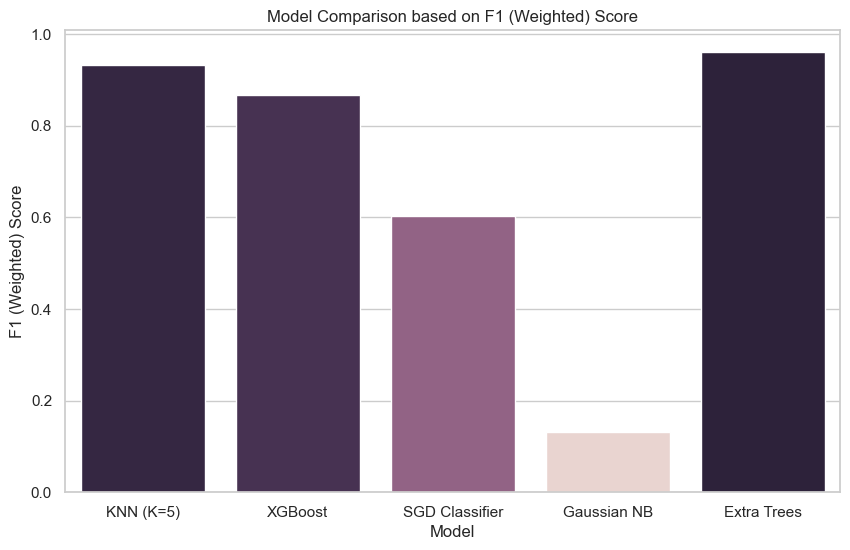

In [14]:
sns.barplot(x=results_df.index, y='F1_Weighted_CV', data=results_df, hue='F1_Weighted_CV', legend=False)
plt.title('Model Comparison based on F1 (Weighted) Score')
plt.xlabel('Model')
plt.ylabel('F1 (Weighted) Score')
plt.show()

# 5. Final Evaluation on the Test Set

1.  **Retraining the Best Model**
2.  **Predicting on the Test Set**
3.  **Evaluating Performance**

In [15]:
print("\n--- Starting Final Evaluation on the Test Set ---")

best_model_name = results_df['F1_Weighted_CV'].idxmax()
best_model = models[best_model_name] # pyright: ignore[reportArgumentType]

print(f"The best model from CV is: {best_model_name}")
print(f"Training the final model {best_model_name} on the entire training set...")

start_time = time()
best_model.fit(X_train_processed, y_train)
elapsed = time() - start_time
print(f"Model trained in {elapsed:.2f}s.")

print("Performing prediction on the test set...")
y_pred = best_model.predict(X_test_processed)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred))

print("\nOverall metrics on the test set:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


--- Starting Final Evaluation on the Test Set ---
The best model from CV is: Extra Trees
Training the final model Extra Trees on the entire training set...
Model trained in 9.25s.
Performing prediction on the test set...

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     42368
           1       0.96      0.98      0.97     56661
           2       0.95      0.97      0.96      7151
           3       0.91      0.88      0.89       549
           4       0.95      0.85      0.89      1899
           5       0.95      0.91      0.93      3473
           6       0.97      0.96      0.97      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.96      0.96      0.96    116203


Overall metrics on the test set:
Balanced Accuracy: 0.9282
F1 Score (Weighted): 0.9633


# 6. Results Interpretation and Feature Importance

In this final step, the results of the best-performing model is interpreted.

For tree-based models like Random Forest and XGBoost, there is feature importance, so the top 15 will be printed


--- Starting Interpretation of Results ---
Generating Confusion Matrix...


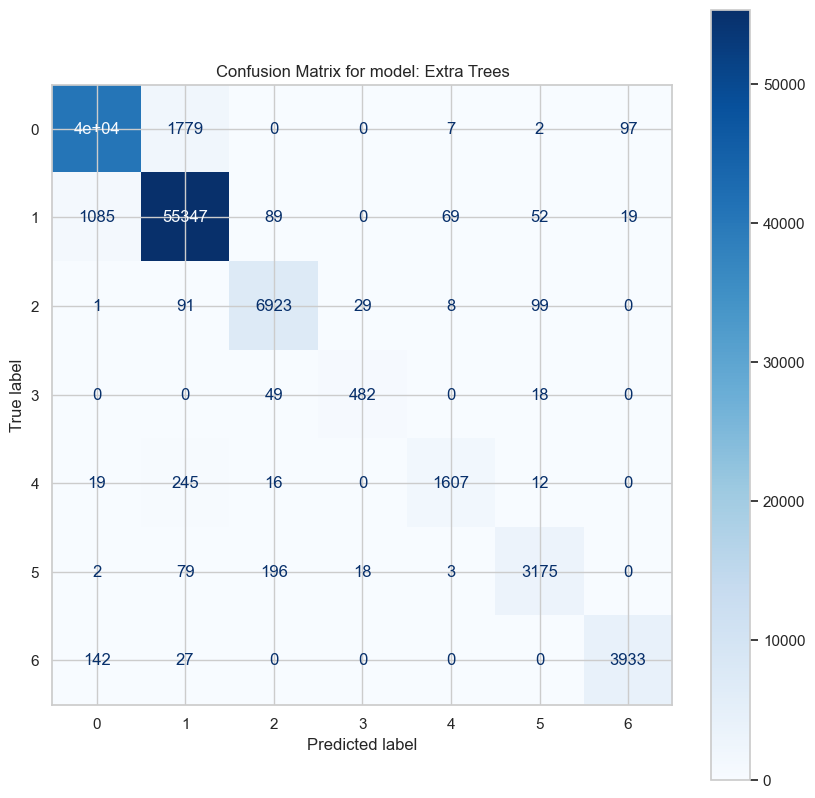


Generating Feature Importance for Extra Trees...

Top 15 most important features:
                                      feature  importance
0                            scale__Elevation    0.196498
5      scale__Horizontal_Distance_To_Roadways    0.107765
7   scale__Horizontal_Distance_To_Fire_Points    0.093232
3     scale__Horizontal_Distance_To_Hydrology    0.065985
1                               scale__Aspect    0.058890
4       scale__Vertical_Distance_To_Hydrology    0.052559
6                        scale__Hillshade_9am    0.050584
2                                scale__Slope    0.042398
49                remainder__Wilderness_Area3    0.037962
18                     remainder__Soil_Type10    0.032868
8                 remainder__Wilderness_Area1    0.032543
11                      remainder__Soil_Type3    0.029990
46                     remainder__Soil_Type38    0.025002
47                     remainder__Soil_Type39    0.022670
12                      remainder__Soil_Type4  

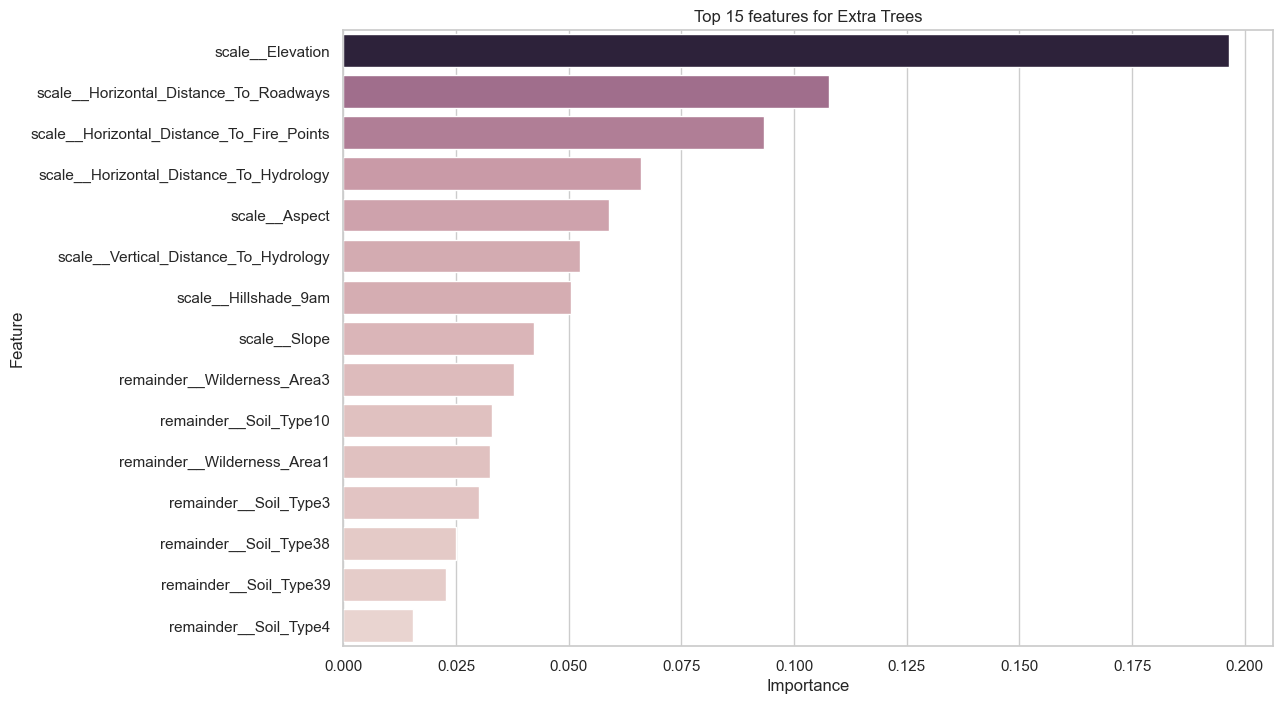


--- The end ---


In [16]:
print("\n--- Starting Interpretation of Results ---")

# Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)

# Plotting the matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax) # pyright: ignore[reportAttributeAccessIssue]
plt.title(f'Confusion Matrix for model: {best_model_name}')
plt.show()


# Feature Importance
# This is only available for tree-based models
if hasattr(best_model, 'feature_importances_'):
    print(f"\nGenerating Feature Importance for {best_model_name}...")
    
    importances = best_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    top_15_features = importance_df.head(15)
    bottom_15_features = importance_df.tail(15)

    print("\nTop 15 most important features:")
    print(top_15_features)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_15_features, hue='importance', legend=False)
    plt.title(f'Top 15 features for {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
else:
    print(f"Model {best_model_name} does not directly support 'feature_importance_'.")

print("\n--- The end ---")